In [38]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
import numpy as np
import scipy.stats as st
import plotly.express as px
import plotly.graph_objects as go
from skimage import io
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
from skimage import io
import skimage

import warnings
warnings.simplefilter("ignore", UserWarning)

import napari
%matplotlib inline

In [39]:
def pad_img(img, new_size):
    new_x, new_y, new_z = new_size[0], new_size[1], new_size[2]
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    delta_z = new_z - z
    delta_y = new_y - y
    delta_x = new_x - x

    if delta_z%2 == 1:
        z_padding = (delta_z//2, delta_z//2 + 1)
    else:
        z_padding = (delta_z//2, delta_z//2)

    if delta_y%2 == 1:
        y_padding = (delta_y//2, delta_y//2 + 1)
    else:
        y_padding = (delta_y//2, delta_y//2)

    if delta_x%2 == 1:
        x_padding = (delta_x//2, delta_x//2 + 1)
    else:
        x_padding = (delta_x//2, delta_x//2)
        
    padded_data = np.pad(img, (x_padding, y_padding, z_padding), 'constant', constant_values=(0))
    return padded_data


def get_max_dims_images(img_dir, df, num=0):
    xmax = 0
    ymax = 0
    zmax = 0
    for i in range(len(df)):
        cell_id = df['serialNumber'][i]
        plate = df[df['serialNumber'] == cell_id]['PlateNum'].values[0]
        p = img_dir + 'Plate' + str(int(plate)) + '/' + 'stacked/Cells/' + cell_id + '.tif'
        img = io.imread(p)
        x, y, z = img.shape[0], img.shape[1], img.shape[2]
        if x > xmax:
            xmax = x
            
        if y > ymax:
            ymax = y
            
        if z > zmax:
            zmax = z
            
    return xmax, ymax, zmax


def imscatter(x, y, image, image_name, all_images, maxdim, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        final_path = path + image
        
        img = io.imread(final_path)
        img = pad_img(img, (maxdim, maxdim, maxdim))
        layer = viewer.add_image(img, rotate = (-30,0,0), rendering='iso')
        screenshot = viewer.screenshot()
        save_p = save  + image_name + '.png'
        image = screenshot
        all_images.append(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    new_x = []
    new_y = []
    
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists


def plot_feature_landscape():
    maxx, maxy,maxz = get_max_dims_images(path,df)
    maxall = max(maxx,maxy,maxz)
    
    fig, ax = plt.subplots()
    all_images = []

    for x, y, image_path, plate in zip(df['Umap1'], df['Umap2'], df['serialNumber'], df['PlateNum']):
          
        viewer = napari.Viewer(ndisplay=3)
        viewer.scale_bar.visible = True
        temp_path = 'Plate' + plate + '/stacked/Cells/' + image_path + '.tif'
        imscatter(x, y, temp_path, image_path, all_images, maxall, zoom=0.07, ax=ax)
        ax.scatter(x, y)
        viewer.close()
        
    plt.title('', fontsize=60)       
    plt.xlabel("UMAP 1", fontsize=60)
    plt.ylabel("UMAP 2", fontsize=60)
    plt.xticks(fontsize=60)
    plt.yticks(fontsize=60)
    plt.savefig(figures_path + 'landscape_diffumap.png', dpi=500, bbox_inches="tight")
    return all_images


In [42]:
extracted_df = pd.read_csv('/home/mvries/Documents/Datasets/OPM/SingleCellFromNathan_17122021/dgcnn_foldingnet_128_001_cell_updated.csv') 
np.random.seed(42)
scalar = StandardScaler()
scaled_features = scalar.fit_transform(np.asarray(extracted_df.iloc[:,0:128]))
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(scaled_features)
b = np.zeros((len(embedding), 2))
b[:, 0] = embedding[:, 0]
b[:, 1] = embedding[:, 1]

extracted_df["UMAP1"] = embedding[:, 0]
extracted_df["UMAP2"] = embedding[:, 1]

# Extract x and y
x = extracted_df["UMAP1"].values
y = extracted_df["UMAP2"].values

# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY


# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)


fig = go.Figure(data=[go.Surface(z=f, x=xx, y=yy)])
fig.update_coloraxes(colorbar_orientation='h')
fig.update_layout(autosize=False,
                  scene_camera_eye=dict(x=1.25, y=-1.25, z=2.5),
                  width=800, height=800,
                  margin=dict(l=85, r=180, b=65, t=90)
                 )
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(scene=dict(
                    xaxis_title='UMAP 1',
                    yaxis_title='UMAP 2',
                    zaxis_title=''),
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    )
)
fig.update_layout(coloraxis_colorbar_x=-1.15)
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[-1,12],),
        yaxis = dict(nticks=4, range=[-2.5,10],),
        zaxis = dict(nticks=4, range=[0,0.06],),))

fig.show()

((48, 49), (33, 34), (55, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((25, 25), (12, 12), (56, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((45, 46), (53, 53), (55, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((53, 54), (51, 52), (54, 54))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(151, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(151, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((39, 39), (28, 29), (58, 58))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((18, 19), (34, 34), (56, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((52, 53), (49, 49), (46, 46))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((52, 52), (56, 57), (52, 53))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((37, 38), (25, 25), (57, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((27, 28), (12, 12), (56, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((35, 35), (46, 46), (56, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((57, 57), (58, 59), (59, 59))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(151, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(151, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((38, 39), (50, 51), (49, 49))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((46, 46), (34, 34), (59, 59))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((50, 50), (50, 51), (52, 53))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((17, 17), (0, 0), (57, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((46, 47), (49, 49), (47, 47))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(191, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(191, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((48, 48), (48, 48), (54, 54))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((55, 56), (55, 55), (55, 55))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((52, 52), (40, 41), (58, 59))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((45, 46), (27, 27), (57, 58))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((47, 48), (36, 37), (58, 58))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(167, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(167, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((48, 49), (49, 50), (54, 54))


Exception in callback BaseAsyncIOLoop._handle_events(175, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(175, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((46, 46), (43, 43), (49, 50))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((17, 17), (45, 46), (46, 47))
((46, 46), (38, 39), (56, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((42, 42), (43, 43), (59, 60))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((54, 55), (54, 54), (52, 52))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((45, 45), (51, 52), (55, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((55, 56), (52, 53), (53, 54))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((16, 16), (39, 40), (56, 56))


Exception in callback BaseAsyncIOLoop._handle_events(167, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(167, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((51, 52), (53, 53), (52, 53))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((59, 59), (53, 53), (60, 60))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((61, 61), (57, 58), (57, 58))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((45, 46), (46, 47), (55, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((37, 37), (35, 35), (57, 58))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((36, 37), (30, 30), (57, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(139, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(139, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((55, 56), (58, 58), (57, 58))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(151, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(151, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((35, 36), (30, 31), (43, 43))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(159, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(159, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((53, 54), (39, 40), (44, 44))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((59, 59), (49, 50), (58, 59))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((35, 36), (34, 34), (48, 48))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(183, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(183, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((33, 33), (43, 44), (56, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((10, 10), (26, 26), (58, 59))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((32, 32), (20, 21), (55, 55))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((42, 43), (29, 30), (56, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((13, 14), (24, 24), (53, 54))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(151, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(151, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((49, 49), (50, 50), (40, 41))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((48, 49), (18, 18), (56, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((33, 34), (21, 22), (56, 56))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((52, 52), (49, 50), (54, 54))
((49, 49), (21, 22), (57, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((48, 49), (56, 56), (56, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(199, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(199, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((58, 58), (58, 59), (60, 61))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((58, 58), (59, 60), (56, 57))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(139, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(139, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((58, 59), (53, 54), (59, 60))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(151, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(151, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((52, 52), (50, 51), (50, 50))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(159, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(159, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

NameError: name 'figures_path' is not defined

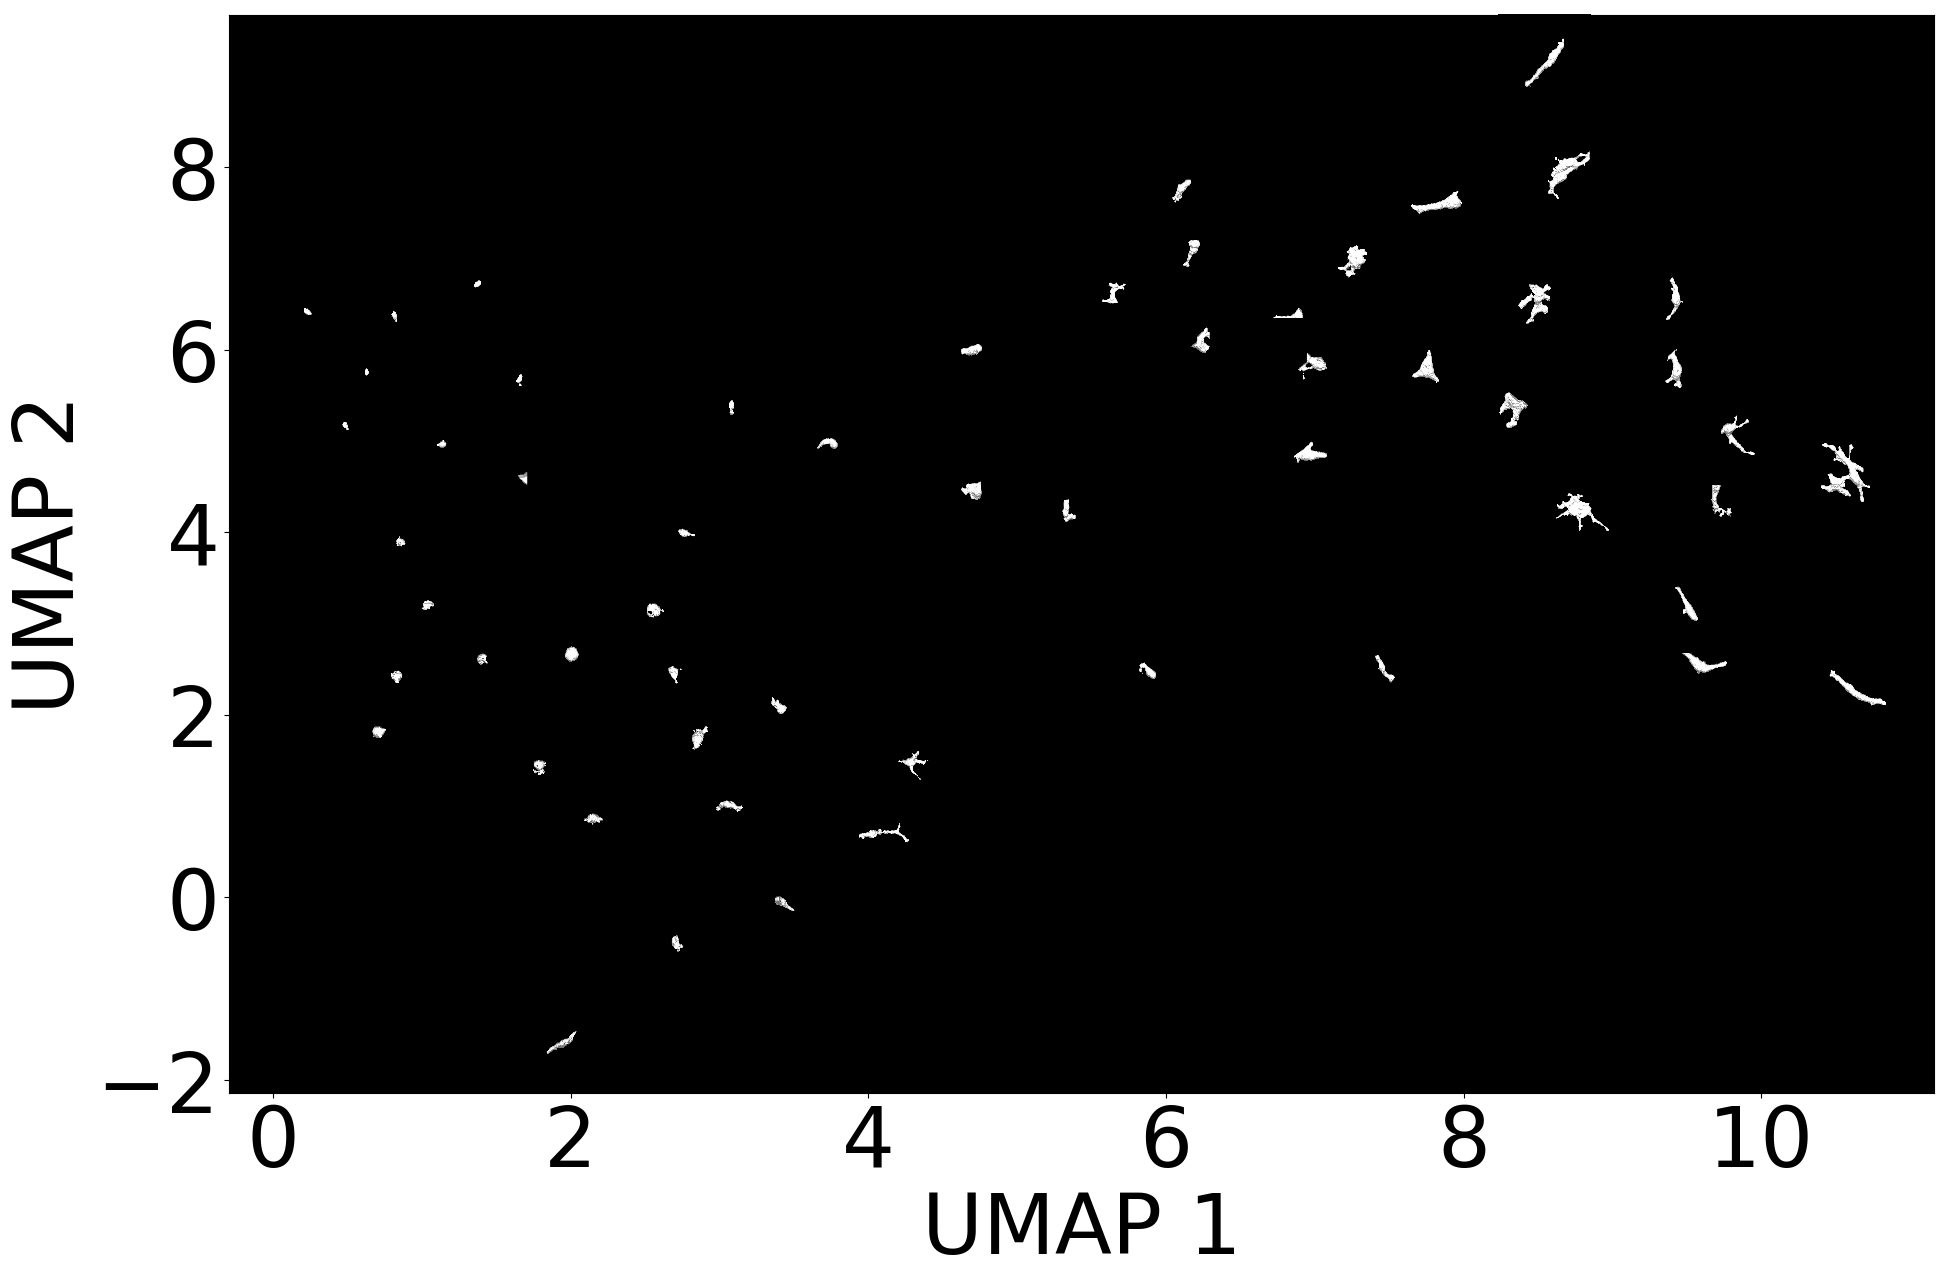

In [44]:
extracted_df['PlateNum'] = [file[37:38] for file in extracted_df['serialNumber'].values]
samples = extracted_df.sample(n=100)
new_x = []
new_x.append(-10)
new_y = []
new_y.append(-10)
new_serial = []
new_serial.append(-10)
new_plate = []
new_plate.append(-10)

for i in range(len(samples['UMAP1'])):
    curr_x = samples['UMAP1'].iloc[i]
    curr_y = samples['UMAP2'].iloc[i]
    for j in range(len(new_x)):
        if (abs(curr_x - new_x[j]) < 0.5) & (abs(curr_y - new_y[j]) < 0.5):
            add = False
            
            break
        else:
            add = True
    
    if add:
        new_x.append(curr_x)
        new_y.append(curr_y)
        new_serial.append(samples['serialNumber'].iloc[i])
        new_plate.append(samples['PlateNum'].iloc[i])
        
d = {'Umap1':new_x[1:],'Umap2':new_y[1:], 'serialNumber': new_serial[1:], 'PlateNum': new_plate[1:]}
df = pd.DataFrame(d)

plt.style.use(style='default')
plt.rcParams['figure.figsize'] = (22, 14)
plt.rcParams['axes.facecolor'] = 'black'

all_images = plot_feature_landscape()

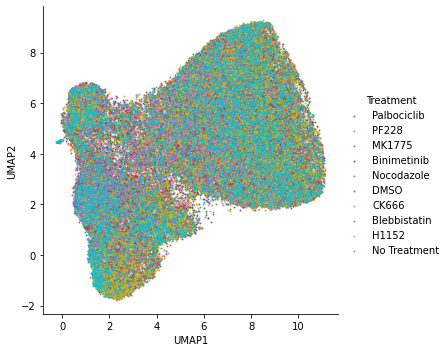

-1.3858231365680695 12.272879219055175 -2.88025758266449 10.37639102935791


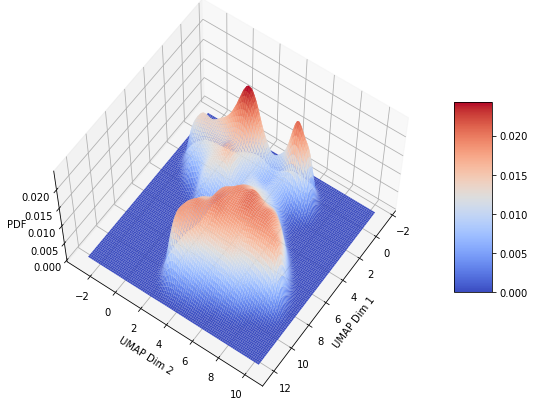

((56, 57), (34, 34), (69, 69))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((46, 46), (67, 68), (63, 63))


Exception in callback BaseAsyncIOLoop._handle_events(140, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(140, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((37, 38), (53, 53), (70, 71))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((53, 53), (58, 58), (49, 50))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((48, 49), (56, 56), (64, 64))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((50, 51), (67, 68), (65, 65))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((45, 46), (56, 57), (61, 62))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((53, 54), (57, 57), (47, 47))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((38, 38), (57, 57), (70, 71))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((47, 47), (56, 57), (68, 69))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(140, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(140, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((41, 41), (23, 23), (65, 65))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((30, 30), (53, 53), (60, 60))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((51, 51), (27, 28), (71, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(167, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(167, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((49, 49), (61, 62), (70, 70))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(175, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(175, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((69, 69), (67, 67), (70, 71))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((62, 62), (47, 48), (63, 64))


Exception in callback BaseAsyncIOLoop._handle_events(191, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(191, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((63, 63), (63, 63), (59, 60))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((64, 65), (63, 64), (68, 69))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((38, 38), (57, 58), (71, 71))
((48, 49), (41, 41), (67, 67))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((75, 76), (73, 73), (73, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((68, 68), (62, 62), (63, 63))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(175, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(175, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((49, 49), (58, 58), (73, 73))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((59, 60), (45, 45), (73, 74))


Exception in callback BaseAsyncIOLoop._handle_events(191, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(191, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((65, 66), (62, 63), (68, 68))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((32, 33), (44, 45), (45, 45))


Exception in callback BaseAsyncIOLoop._handle_events(140, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(140, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((53, 54), (66, 66), (66, 67))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((62, 63), (57, 57), (68, 68))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((26, 26), (42, 42), (70, 70))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(167, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(167, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((45, 45), (69, 70), (73, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((72, 73), (74, 75), (73, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((57, 57), (44, 45), (71, 71))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((52, 53), (45, 45), (66, 67))


Exception in callback BaseAsyncIOLoop._handle_events(199, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(199, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((70, 70), (69, 70), (63, 63))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((31, 31), (42, 42), (72, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((41, 42), (21, 22), (72, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((57, 58), (59, 60), (71, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((61, 62), (64, 65), (62, 62))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((66, 66), (52, 52), (72, 73))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((61, 61), (63, 64), (74, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((73, 73), (74, 74), (73, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((62, 63), (59, 60), (73, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(132, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(132, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((75, 75), (71, 71), (74, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((63, 64), (59, 59), (72, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((48, 48), (25, 26), (65, 66))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((52, 52), (59, 59), (69, 70))
((61, 61), (59, 60), (69, 69))


Exception in callback BaseAsyncIOLoop._handle_events(175, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(175, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((49, 49), (44, 45), (70, 71))
((54, 55), (48, 49), (71, 71))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((55, 55), (42, 43), (72, 73))


Exception in callback BaseAsyncIOLoop._handle_events(199, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(199, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

((54, 55), (56, 56), (69, 70))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((51, 52), (71, 71), (67, 67))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((37, 37), (53, 53), (71, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((26, 27), (46, 47), (73, 73))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((16, 16), (0, 0), (72, 72))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((65, 66), (60, 60), (72, 73))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(175, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(175, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((42, 42), (51, 51), (73, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
Exception in callback BaseAsyncIOLoop._handle_events(186, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(186, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/

((45, 45), (64, 64), (74, 74))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((68, 68), (69, 69), (67, 68))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((51, 52), (38, 38), (72, 73))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((67, 68), (52, 53), (65, 66))


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/jupyter_client/threaded.py", line 123, in _handle_recv
    msg_list = self.ioloop._asyncio_event_loop.run_until_complete(get_msg(future_msg))
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 592, in run_until_complete
    self._check_running()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/base_events.py", line 554, in _check_running
    raise RuntimeError(
RuntimeError: Cannot run the event loop while another loop is running
ERROR:tornado.general:Uncaught exception in zmqstream callback
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqst

((42, 42), (50, 51), (69, 70))


Exception in callback BaseAsyncIOLoop._handle_events(159, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(159, 1)>
Traceback (most recent call last):
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packages/zmq/eventloop/zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "/home/mvries/anaconda3/envs/cstest/lib/python3.8/site-packa

NameError: name 'figures_path' is not defined

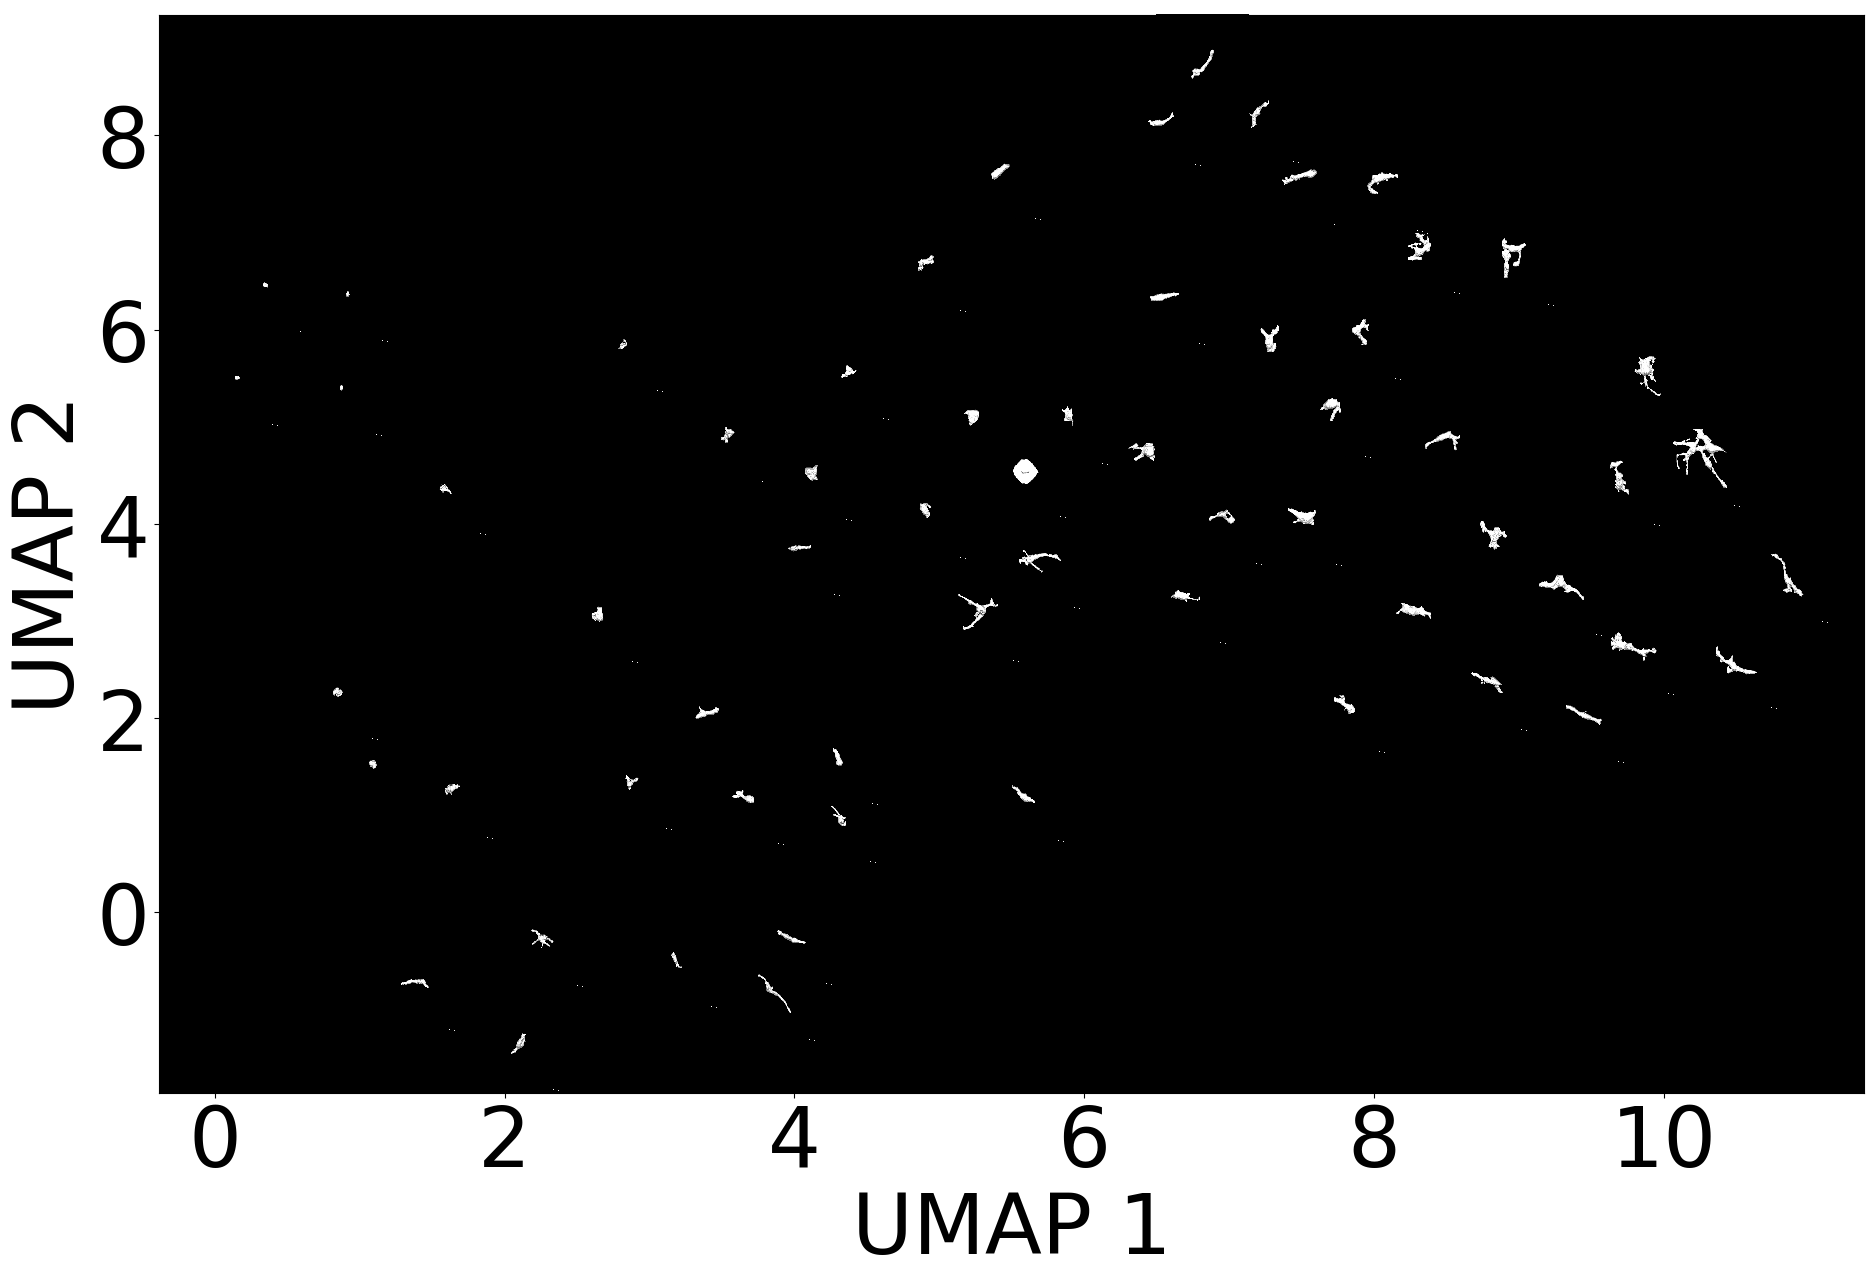